In [142]:
import requests
import numpy as np
import json
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt

In [143]:
def get_emb(word):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {OPENAI_API_KEY}"
    }
    data = {
        "input": word,
        "model": "text-embedding-ada-002"
    }
    response = requests.post("https://api.openai.com/v1/embeddings", json=data, headers=headers)
    return np.array(response.json()["data"][0]["embedding"])

def get_similarity(word1, word2):
    emb1 = get_word_embedding(word1)
    emb2 = get_word_embedding(word2)
    # cosine similarity - OpenAI embeddings are normalized to length 1, so we don't need to divide by the norms
    similarity = np.dot(emb1, emb2) # / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    return similarity

def euclidean_dist(emb1, emb2):
    distance = np.linalg.norm(emb1 - emb2)
    return distance


In [144]:
OPENAI_API_KEY = input("API key: ")

In [145]:
len(get_emb("dog"))

1536

game

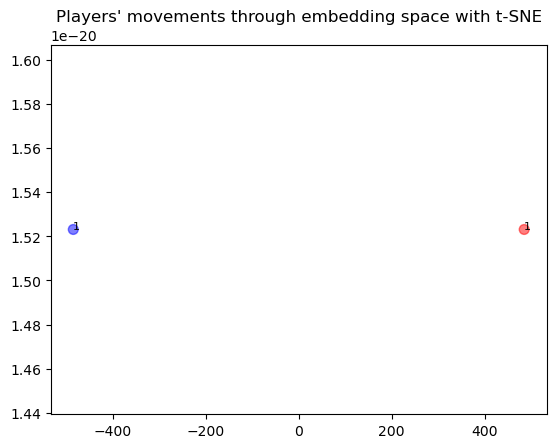

0.8732819084128227


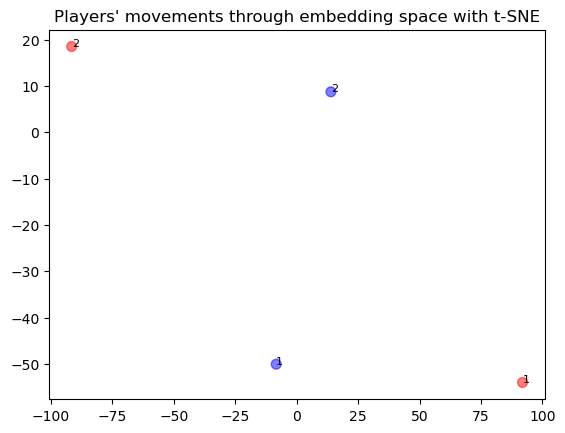

0.8234347645095313


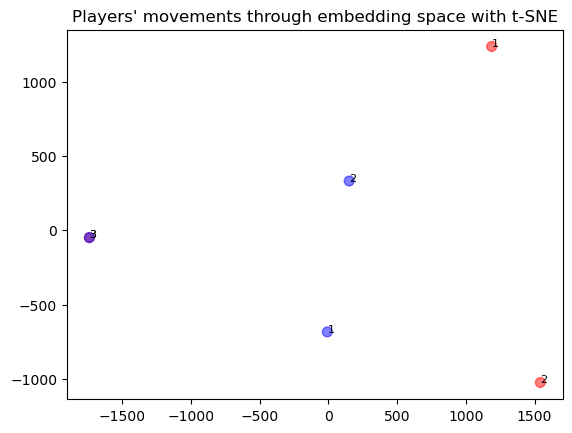

Congratulations! You both chose hat in 3 turn(s).


In [164]:
turns = 1
embeddings = []
words = []
players = []

while True:
    player1_word = input("Player 1, enter your word: ").strip()
    player2_word = input("Player 2, enter your word: ").strip()

    embeddings.append(get_emb(player1_word))
    words.append(player1_word)
    players.append('Player 1')
    embeddings.append(get_emb(player2_word))
    words.append(player2_word)
    players.append('Player 2')

    mat = np.array(embeddings)
    vis = TSNE(n_components=2, perplexity=min(5, turns), random_state=42).fit_transform(mat)
    colors = ["red", "blue"]
    x, y = vis[:, 0], vis[:, 1]
    color_indices = [0 if player == "Player 1" else 1 for player in players]
    plt.scatter(x, y, c=color_indices, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5, s=50)

    # # Highlight Movements for Player 1 and Player 2
    # for player_idx, color in zip([0, 1], ['red', 'blue']):
    #     path = vis[player_idx::2]
    #     plt.plot(path[:, 0], path[:, 1], color=color, linestyle='-', marker='o')
    #     plt.text(path[-1, 0], path[-1, 1], turns, color=color)
    
    for i, point in enumerate(vis):
        plt.text(point[0], point[1], str(i//2 + 1), size=8, color='black')

    plt.title("Players' movements through embedding space with t-SNE")
    plt.show(block=False)
    plt.pause(1)  # Real-time update effect

    if player1_word == player2_word:
        print(f"Congratulations! You both chose {player1_word} in {turns} turn(s).")
        break

    ax.clear()
    similarity = get_similarity(player1_word, player2_word)
    print(similarity)
    turns += 1

In [165]:
df = pd.DataFrame({'emb': embeddings, 'word': words, 'player': players})
df

,emb,word,player
0,"[-0.0070234784, -0.017333334, -0.009631996, -0...",cat,Player 1
1,"[-0.005656318, -0.016416539, -0.018002613, -0....",cow,Player 2
2,"[-0.015702788, -0.01187368, -0.0044258954, -0....",dream,Player 1
3,"[-0.0055895085, -0.0163516, -0.01803286, -0.01...",cow,Player 2
4,"[-0.011753426, -0.010722542, 0.0064091096, -0....",hat,Player 1
5,"[-0.011753426, -0.010722542, 0.0064091096, -0....",hat,Player 2


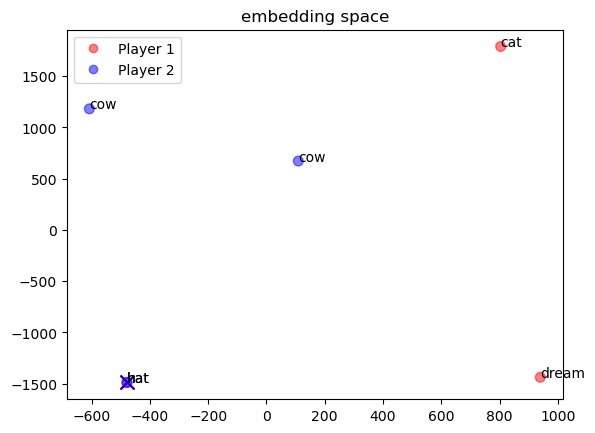

In [166]:
# Visualization
mat = np.array(df.emb.to_list())
perplexity = min(5, turns - 1)
vis = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(mat)

colors = ["red", "blue"]
x, y = vis[:, 0], vis[:, 1]
color_indices = df.player.map({'Player 1': 0, 'Player 2': 1}).values

# add word labels
for i, txt in enumerate(df.word):
    plt.annotate(txt, (x[i], y[i]))

plt.scatter(x, y, c=color_indices, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5, s=50)

# Mark the ending point
plt.scatter(x[-2], y[-2], marker='x', color=colors[0], s=100)
plt.scatter(x[-1], y[-1], marker='x', color=colors[1], s=100)

# add legend to the plot
plt.legend(handles=scatter.legend_elements()[0], labels=['Player 1', 'Player 2'])

plt.title("embedding space")  # t-SNE
plt.show()

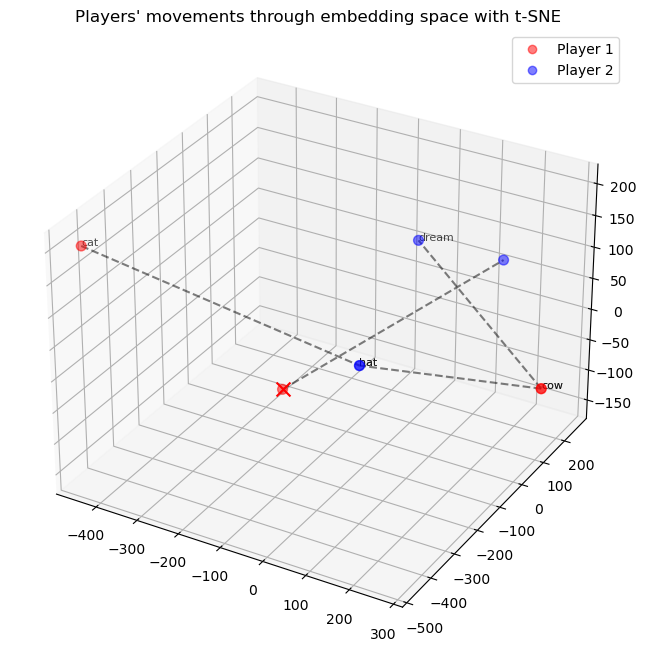

In [151]:
from mpl_toolkits.mplot3d import Axes3D

# Visualization with 3D t-SNE
mat = np.array(df.emb.to_list())
vis = TSNE(n_components=3, perplexity=min(5, turns - 1), random_state=42).fit_transform(mat) # (n_turns*2, 3)

colors = ["red", "blue"]
color_indices = df.player.map({'Player 1': 0, 'Player 2': 1}).values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(vis[:, 0], vis[:, 1], vis[:, 2], c=color_indices, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5, s=50)

# Add word labels
for i, word in enumerate(df.word):
    ax.text(vis[i, 0], vis[i, 1], vis[i, 2], word, size=8, alpha=0.7)
    
# add line for each player
for i in range(0, len(vis), 2):
    ax.plot(vis[i:i+2, 0], vis[i:i+2, 1], vis[i:i+2, 2], color="black", linestyle="dashed", alpha=0.5)
    
# Mark the winning point
ax.scatter(vis[-2, 0], vis[-2, 1], vis[-2, 2], marker='x', color="red", s=100)

# Enhance appearance
ax.set_title("Players' movements through embedding space with t-SNE")
plt.legend(handles=scatter.legend_elements()[0], labels=['Player 1', 'Player 2'])
plt.show()

Preprocess embedding space for 10,000 most common English words

In [126]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for c in colors:
  dist = euclidean_dist(get_emb(c), get_emb('dog'))
  # print(dist)
  print(f'{c}, distance: {dist}')

red, distance: 0.5234136124568036
blue, distance: 0.523162788540831
green, distance: 0.45925946300623166
orange, distance: 0.5076666014917844
purple, distance: 0.48950294065430155
brown, distance: 0.45617944472863076
pink, distance: 0.4964007134466477
gray, distance: 0.4834689980322781
olive, distance: 0.49498872729979765
cyan, distance: 0.541186122281714


In [118]:
# why is it sometimes returning different embeddings for the same word?

check = get_emb("dog")

for i in range(50):
  x = get_emb("puppy") 
  print(check == x)
  print(np.sum((check - x)**2)**0.5)
  

[False False False ... False False False]
0.5019193743229953
[False False False ... False False False]
0.5017859643398234
[False False False ... False False False]
0.5019193743229953
[False False False ... False False False]
0.5019193743229953
[False False False ... False False False]
0.5019193743229953
[False False False ... False False False]
0.5019193743229953
[False False False ... False False False]
0.5019193743229953
[False False False ... False False False]
0.5019193743229953
[False False False ... False False False]
0.501751784267932
[False False False ... False False False]
0.5019193743229953


KeyboardInterrupt: 